In [1]:
# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

# Data manipulation
import numpy as np
import pandas as pd

# WordCloud and NLP
from wordcloud import WordCloud
import nltk
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Regular expressions
import re

In [2]:
#!pip install wordcloud



In [3]:
data=pd.read_csv("D:/datasets/Corona_NLP_test.csv")

In [4]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [5]:
data['Sentiment'].value_counts()

Negative              1041
Positive               947
Neutral                619
Extremely Positive     599
Extremely Negative     592
Name: Sentiment, dtype: int64

In [6]:
def change_sen(sentiment):
    if sentiment=='Extremely Positive':
        
        return 'positive'
    
    elif sentiment=='Extremely Negative':
        return 'negative'
    
    elif sentiment== 'Positive':
        
        return "positive"
    
    elif sentiment== 'Negative':
        
        return 'negative'
    
    else:
        return "neutral"

In [7]:
data['Sentiment'] = data['Sentiment']. apply (lambda x: change_sen(x))

In [8]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,neutral


In [9]:
data.shape

(3798, 6)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


In [11]:
#Missing Values
print(f' missinga value in percentage{data.isnull().sum()/len(data)*100}')

 missinga value in percentageUserName          0.000000
ScreenName        0.000000
Location         21.958926
TweetAt           0.000000
OriginalTweet     0.000000
Sentiment         0.000000
dtype: float64


In [12]:
#Drop missing value from that column
data=data.dropna(subset=['Location'])

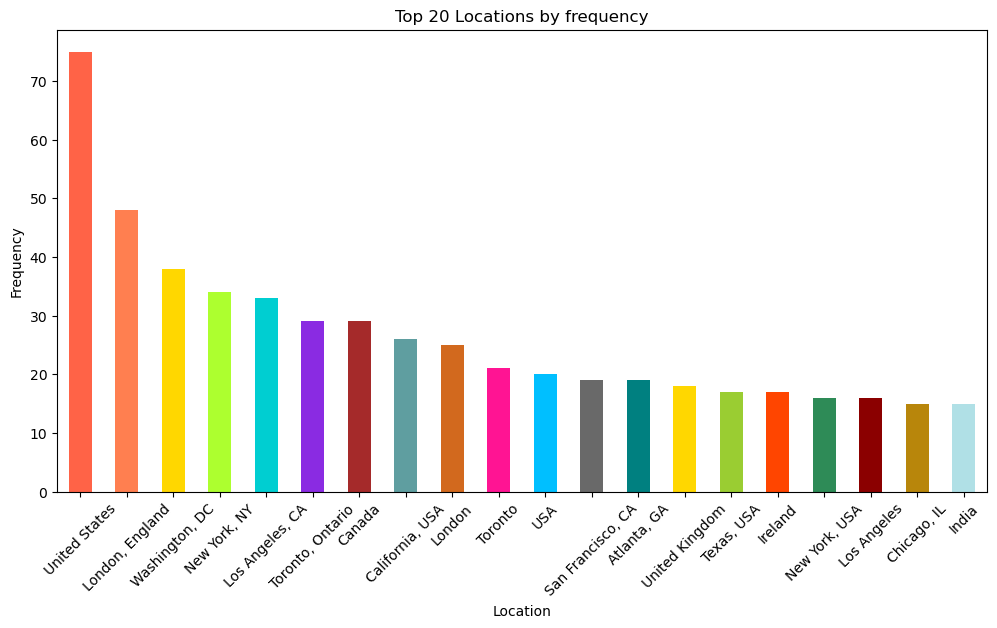

In [13]:
#Count values in the location column and get the top 20
top_20 = data['Location'].value_counts().head(20)

# Custom colors for the bars
colors = ['#FF6347', '#FF7F50', '#FFD700', '#ADFF2F', '#00CED1', 
          '#8A2BE2', '#A52A2A', '#5F9EA0', '#D2691E', '#FF1493', 
          '#00BFFF', '#696969', '#008080', '#FFD700', '#9ACD32', 
          '#FF4500', '#2E8B57', '#8B0000', '#B8860B', '#B0E0E6']

top_20.plot(kind='bar', color=colors, rot=45, figsize=(12,6))

plt.title("Top 20 Locations by frequency")
plt.ylabel('Frequency')
plt.xlabel('Location')
plt.show()

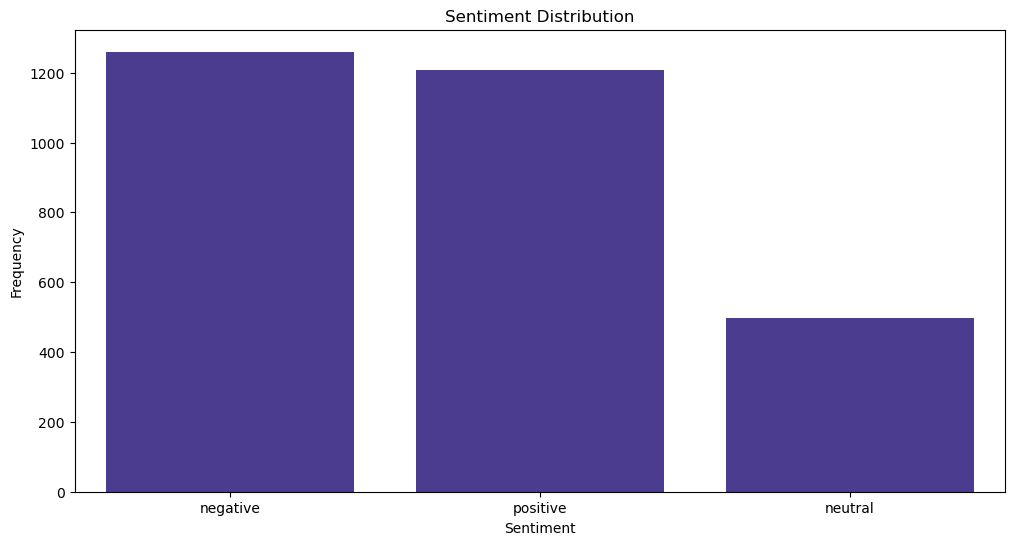

In [14]:
#plot sentiment distribution

plt.figure(figsize=(12,6))
sns.countplot(x='Sentiment', data=data, color='#422e9e')
plt.title('Sentiment Distribution')
plt.ylabel('Frequency')
plt.xlabel('Sentiment')
plt.show()



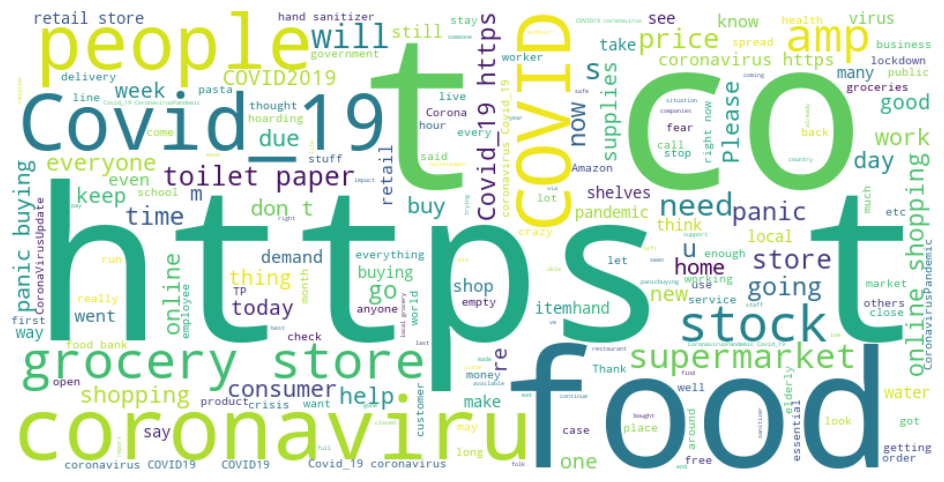

In [15]:
#wordcloud for frequently used word in the tweet

text=" ".join(tweet for tweet in data['OriginalTweet'] if isinstance(tweet,str) ) #ensures tweet is a string
wordcloud = WordCloud(width=800, height=400, background_color='White').generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

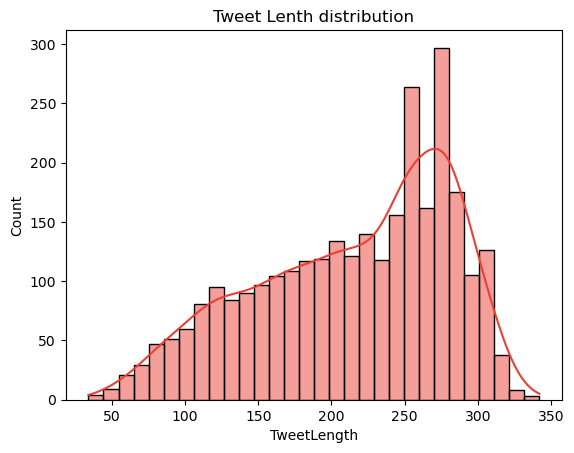

In [16]:
data['TweetLength']=data['OriginalTweet'].apply(len)
sns.histplot(data['TweetLength'],bins=30, kde=True,color="#eb4034")
plt.title('Tweet Lenth distribution')
plt.show()

In [17]:
data['Sentiment'].value_counts()

negative    1260
positive    1207
neutral      497
Name: Sentiment, dtype: int64

# Preprocessing


In [23]:
# Load stopwords
stop_words = set(stopwords.words('english'))

# Define the text cleaning function
def data_cleaner(tweet):
    tweet = re.sub(r'http\S+', ' ', tweet)  # Remove URLs
    tweet = re.sub(r'<.*?>', ' ', tweet)  # Remove HTML tags
    tweet = re.sub(r'\d+', ' ', tweet)  # Remove digits
    tweet = re.sub(r'#[^\s]+', '', tweet)  # Remove hashtags
    tweet = re.sub(r'@\w+', ' ', tweet)  # Remove mentions
    
    # Remove stopwords
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if word.lower() not in stop_words])
    
    return tweet

# Load data
X = data['OriginalTweet'].copy()
y = data['Sentiment'].copy()

# Clean text data
X_cleaned = X.apply(data_cleaner)

# Encode sentiment labels
text_mapping = {'neutral': 0, 'positive': 1, 'negative': 2}
y = y.map(text_mapping)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_cleaned, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Tokenize only on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, padding='post')
X_val_pad = pad_sequences(X_val_seq, padding='post')
X_test_pad = pad_sequences(X_test_seq, padding='post')

# Get vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 7529


In [24]:
y.head()

0    2
1    1
3    2
4    0
5    0
Name: Sentiment, dtype: int64

In [25]:
print(f"Length of X_cleaned: {len(X_cleaned)}")
print(f"Length of y: {len(y)}")

Length of X_cleaned: 2964
Length of y: 2964


In [26]:
# Hyperparameters
EPOCHS = 20  # More epochs with early stopping
BATCH_SIZE = 32
embedding_dim = 16
units = 256

# Define the model
model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim),  
    L.Bidirectional(L.LSTM(units, return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(64, activation="relu"),
    L.Dropout(0.4),
    L.Dense(3)  # 3 classes (neutral, positive, negative)
])

# Compile the model
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,  # Stop if val_loss doesn't improve for 3 epochs
    restore_best_weights=True  # Restore best weights
)

# Train the model
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping]  # Apply early stopping
)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 176ms/step - accuracy: 0.4182 - loss: 1.0449 - val_accuracy: 0.4628 - val_loss: 0.9702
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 168ms/step - accuracy: 0.4562 - loss: 0.9452 - val_accuracy: 0.4662 - val_loss: 0.9476
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.5268 - loss: 0.8023 - val_accuracy: 0.4730 - val_loss: 0.9334
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.5906 - loss: 0.6789 - val_accuracy: 0.5270 - val_loss: 0.9508
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.6346 - loss: 0.6857 - val_accuracy: 0.6115 - val_loss: 0.8981
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.7761 - loss: 0.5657 - val_accuracy: 0.5845 - val_loss: 1.0602
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step - accuracy: 0.9079 - loss: 0.2562 - val_accuracy: 0.6250 - val_loss: 1.2160
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 17s 228ms/step - accuracy: 0.9641 - loss: 0.1178 - val_accu

In [27]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=1)
print(f"\nTest Accuracy: {test_acc:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.5798 - loss: 0.8375

Test Accuracy: 0.5623


In [ ]:
#X=data['OriginalTweet'].copy()
#y=data['Sentiment'].copy()

In [ ]:
##def data_cleaner (tweet):
    
    #remove urls
 #   tweet= re.sub(r'http\S+', ' ', tweet)
    
    #remove html tags
 #     tweet= re.sub(r'<.*?>', ' ', tweet)
    
    #remove digits
    #  tweet= re.sub(r'\d+', ' ', tweet)
    
    #remove hashtags
  #    tweet = re.sub(r'#[^\s]+', '', tweet)
    
    #remove mentions
 #     tweet= re.sub(r'@\w+', ' ', tweet)
    
    #remove stopwords
    #  tweet=tweet.split()
    tweet= " ". join([word for word in tweet if not word in stop_words])
    
    
    return tweet

stop_words= set(stopwords.words('english'))
X_cleaned= X.apply(data_cleaner)
X_cleaned.head()

# Tokenization

In [ ]:
X_cleaned = X_cleaned.reset_index(drop=True)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer=Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

X=tokenizer.texts_to_sequences(X_cleaned)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

# Show example
print(f"\nSentence:\n{X_cleaned[6]}")
print(f"\nAfter tokenizing:\n{X[6]}")

# Pad sequences
X = pad_sequences(X, padding='post')
print(f"\nAfter padding:\n{X[6]}")

# # LABELS

In [ ]:
text={'neutral':0, 'positive':1, 'negative':2}
data['Sentiment']=data['Sentiment'].map(text)

y.replace(text, inplace=True)
y.head()

In [ ]:
y.shape

# The Model

In [ ]:
from tensorflow.keras import layers as l
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Hyperparameters
EPOCHS = 10
BATCH_SIZE = 32
embedding_dim = 16
units = 256


# Define the model
model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim),  # Removed input_length argument
    L.Bidirectional(L.LSTM(units, return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(64, activation="relu"),
    L.Dropout(0.4),
    L.Dense(3)  # Assuming 3 classes for classification
])

# Compile the model
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy']
)

# Model Compilation

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size=0.2, random_state=42)



history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping]  # Include early stopping callback
)
loss, accuracy = model.evaluate(X_val, y_val)
print(f"\nValidation Accuracy: {accuracy:.4f}")

In [ ]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


In [ ]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


In [ ]:
predictions = model.predict(X_val)  # Probabilities
predicted_classes = predictions.argmax(axis=1)  # Convert to sentiment labels


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compare predictions with actual validation labels
print(classification_report(y_val, predicted_classes))

# Confusion Matrix
cm = confusion_matrix(y_val, predicted_classes)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
